In [128]:
import pickle 

file_path = './GRUPlus_all_data'

# Open the pickled file in read mode
with open(file_path, 'rb') as file:
    # Load the pickled object
    loaded_object = pickle.load(file)

# Now you can use the loaded_object
print(loaded_object.keys())

dict_keys(['model', 'split_ratio', 'returns', 'result_portfolio_value', 'x', 'y', 'y_pred_test', 'y_true_test'])


In [129]:
loaded_object['result_portfolio_value']

3.8807152129322144

In [130]:
from sklearn.metrics import mean_absolute_error
import numpy as np


returns= np.array(loaded_object["returns"])
real= np.array(loaded_object["y_true_test"])
preds = np.array(loaded_object["y_pred_test"])
print(f'total profit 0% fee {(loaded_object["result_portfolio_value"]-1)*100}')
print(f'mean return per trade {returns.mean()}')
print(f'total profit 1% fee {(np.prod((returns/100 +1) *0.99)-1)*100}')
print(f'total profit 3% fee {(np.prod((returns/100 +1) *0.97)-1)*100}')
print(f'total profit 5% fee {(np.prod((returns/100 +1) *0.95)-1)*100}')
print(f'MAE :{mean_absolute_error(real, preds)}') 
print(f'MSE: {np.mean((real-preds)**2)}')

total profit 0% fee 288.07152129322145
mean return per trade 11.398404836654663
total profit 1% fee 233.76415408658963
total profit 3% fee 145.74675232905525
total profit 5% fee 79.79013248990334
MAE :1.199818730354309
MSE: 4.7261247634887695


In [90]:
#directional accuracy
total= 0
correct= 0
for i in range(preds.shape[-1]): #for each item
    prev_val = real[0]
    for pr, rl in zip(preds[1:], real[1:]):
        total+= 1
        if prev_val[i] > pr[i] and rl[i] > pr[i]:
            correct+= 1
        if prev_val[i] < pr[i] and rl[i] < pr[i]:
            correct+= 1
        prev_val = rl
        
print(f"Directional accuracy {correct/total *100}")

Directional accuracy 95.21640091116174


In [93]:
#random benchmark
import random 
portf= 1.0
entry= None
entry_idx= None
y= loaded_object["y_true_test"]
trade_len =30
trade_len_var= 5
waiting= 0
profits= []


for i, curr_y in enumerate(y):
    if entry is None:
        if random.randint(0,1) == 1:
            waiting = 0
            entry_idx = random.randint(0,len(curr_y)-1)
            entry = curr_y[entry_idx]
    else:
        if random.randint(0,1) == 0:
            profit = entry / curr_y[entry_idx]
            portf *= profit
            profits.append((profit*0.99-1.0)*100)
            entry = None
            entry_idx = None
            
print(f'profit random (no fees) {(portf-1.0) *100}')
print(f'number of trades {len(profits)}')
print(f'avg trade: {np.mean(profits)} %')

profit random (no fees) -26.692929627190352
number of trades 97
avg trade: -1.275074056128867 %


In [136]:
def backtest_predictions(prev_price, preds, true_vals, trashold=0.0, verbose = True):
    assert len(preds) == len(true_vals)
    returns=[]
    entry= None
    entry_idx= None
    portf= 1.0
    for i in  range(0, len(preds)):
        
        difference= preds[i] -  prev_price
        if entry_idx is None:
            curr_trade_idx= np.argmax(difference / prev_price)
        else:
            curr_trade_idx= entry_idx
            
        if entry is None:
            if difference[curr_trade_idx] > trashold:
                entry= prev_price[curr_trade_idx]
                entry_idx= curr_trade_idx
        else:
            if preds[i][entry_idx] < prev_price[entry_idx]:
                profit = prev_price[entry_idx] / entry
                portf*= profit
                returns.append(profit)
                entry= None
                entry_idx= None
        prev_price= true_vals[i]
    
    returns= np.array(returns)
    if verbose:
        print(f'profit : {(portf - 1.0)*100} %')
        print(f'mean return per trade {(np.mean(returns) -1) *100}')
        print(f'total profit 1% fee {(np.prod(returns *0.99)-1)*100}')
        print(f'total profit 2% fee {(np.prod(returns *0.98)-1)*100}')
        print(f'total profit 3% fee {(np.prod(returns *0.97)-1)*100}')
        print(f'total profit 5% fee {(np.prod(returns *0.95)-1)*100}')
    return returns

In [137]:
true_vals= loaded_object['y_true_test']
prev_price = true_vals[0]
returns=  backtest_predictions(prev_price, true_vals[1:], true_vals[1:], trashold=0.0)

profit : 1190033.3052005589 %
mean return per trade 6.647002696990967
total profit 1% fee 253072.3876953125
total profit 2% fee 52916.705322265625
total profit 3% fee 10825.57601928711
total profit 5% fee 341.6007995605469


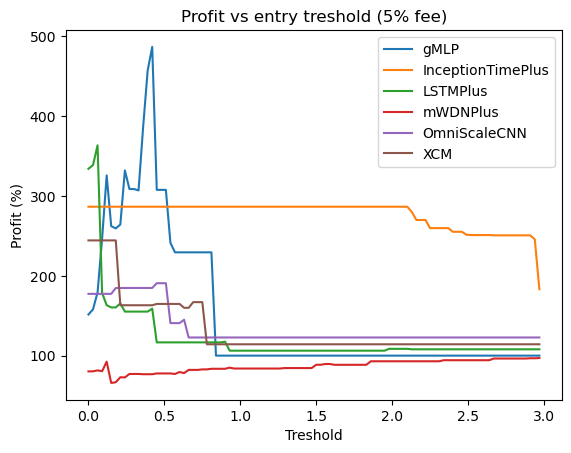

In [179]:
#entry treshold influence
import matplotlib.pyplot as plt

tresholds= np.arange(0.0, 3.0, 0.03)
models= ["gMLP", "InceptionTimePlus", "LSTMPlus", "mWDNPlus", "OmniScaleCNN", "XCM"]
all_results=[]
for model in models:
    model_result= []
    with open(model, 'rb') as file:
        loaded_object = pickle.load(file)
        preds= loaded_object['y_pred_test'] 
        true_vals= loaded_object['y_true_test']
        prev_price = true_vals[0]
    for treshold in tresholds:
        profits = backtest_predictions(prev_price, preds[1:], true_vals[1:], trashold=treshold, verbose=False)
        profits = profits * 0.95 #5% fee
        model_result.append(np.prod(profits))
    all_results.append(model_result)
all_results= np.array(all_results)

for r, label in zip(all_results, models):
    plt.plot(tresholds, r*100, label=label)

plt.title("Profit vs entry treshold (5% fee)")
plt.xlabel("Treshold")
plt.ylabel("Profit (%)")
 
plt.legend()
plt.show()